In [1]:
import pickle

from info_nas.datasets.arch2vec_dataset import prepare_labeled_dataset, split_off_valid
from info_nas.datasets.io.semi_dataset import labeled_network_dataset
from info_nas.datasets.io.transforms import get_transforms, get_all_scales
from info_nas.models.utils import load_extended_vae 

from info_nas.config import local_dataset_cfg, load_json_cfg

scale_cfg = '../configs/model_config.json'
scale_dir = '../data/scales/'

with open('../data/nasbench.pickle', 'rb') as f:
    nb = pickle.load(f)

# load all scaling
scale_cfg = load_json_cfg(scale_cfg)

scale_config = scale_cfg["scale"]
include_bias = scale_config["include_bias"]
normalize = scale_config["normalize"]
multiply_by_weights = scale_config["multiply_by_weights"]
use_scale_whole = scale_config["scale_whole"]

scale_train, scale_valid, scale_whole = get_all_scales(scale_dir, scale_config)
print(f"Scale paths: {scale_train}, {scale_valid}, {scale_whole}")

def get_data_loader(dataset, scale_name, split_ratio=0.9):
    transforms = get_transforms(scale_train if scale_name == "train" else scale_valid,
                                include_bias, normalize, multiply_by_weights,
                                scale_whole_path=scale_whole)

    key = 'val' if scale_name == 'valid' else scale_name
    dataset, _ = prepare_labeled_dataset(dataset, nb, key=key, remove_labeled=False,
                                         config=local_dataset_cfg)
    
    if scale_name == 'train':
        larger_part, dataset = split_off_valid(dataset, ratio=split_ratio)
        dataset = larger_part

    dataset = labeled_network_dataset(dataset, transforms=transforms)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False,
                                              num_workers=2)
    
    return data_loader


Scale paths: ../data/scales/scale-train-include_bias.pickle, ../data/scales/scale-valid-include_bias.pickle, ../data/scales/whole_scale-axis_0-train-include_bias.pickle


In [2]:
import torch
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
# test_train = get_data_loader('../data/test_train_long.pt', 'train')
test_valid = get_data_loader('../data/test_valid_long.pt', 'valid')

Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Loading labeled dataset from ../data/test_valid_long.pt.


In [3]:
import torch
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model

check_path = '/home/gabi/diplomka/results/with_ref_5/2021-20-07_23-26-03/model_dense_epoch-29.pt'

device = torch.device('cuda')

vae_model, _ = get_arch2vec_model(device=device)
args = [vae_model, 3, 513]
model, chdata = load_extended_vae(check_path, args, device=device)

In [55]:
def gen_it():
    for a in test_valid:
        for i in range(len(a[0])):
            yield [torch.unsqueeze(a_item[i], 0) for a_item in a] 
            
for k in gen_it():
    print(k[1].shape)
    break

torch.Size([1, 7, 5])


In [56]:
from arch2vec.models.configs import configs
from info_nas.eval import eval_labeled_validation
from info_nas.models.losses import losses_dict

loss = losses_dict['L1']()

res_valid_metrics = eval_labeled_validation(model, [k for k in gen_it()], device, configs[4], loss, return_all_metrics=True)
res_valid_metrics

Evaluating model on labeled validation set (154000 batches).


({'val_loss': 0.5208325215420118,
  'MSE': 0.5549394725135183,
  'L1': 0.5208325215420118,
  'val_loss_min': 0.037969209253787994,
  'val_loss_max': 4.703246593475342,
  'val_loss_std': 0.4772926303517947,
  'val_loss_median': 0.36505480110645294},
 {'val_loss': [0.3407512605190277,
   0.15248361229896545,
   0.36074650287628174,
   0.27169081568717957,
   0.4988294243812561,
   0.5843783617019653,
   0.479714035987854,
   0.4078969657421112,
   0.624631404876709,
   0.2071324735879898,
   0.36701980233192444,
   0.20928163826465607,
   0.44904863834381104,
   0.4732159674167633,
   0.39243459701538086,
   0.6965876817703247,
   0.36003145575523376,
   0.4318518340587616,
   0.32179051637649536,
   0.24589012563228607,
   0.264904260635376,
   0.232981339097023,
   0.45730045437812805,
   0.22747613489627838,
   0.34793585538864136,
   0.445254385471344,
   0.15505819022655487,
   0.6411670446395874,
   0.26845279335975647,
   0.4815891981124878,
   0.32896438241004944,
   0.2897211611

In [37]:
all_items = []

for item in test_valid:
    for i in item[-1]:
        all_items.append(i.detach())

In [31]:
import numpy as np
all_mean = torch.Tensor([np.mean(all_items)])

errors = []
for item in all_items:
    errors.append(loss(torch.Tensor(item), all_mean).item())

In [65]:
res_valid_metrics[1]['L1']

[0.3407512605190277,
 0.15248361229896545,
 0.36074650287628174,
 0.27169081568717957,
 0.4988294243812561,
 0.5843783617019653,
 0.479714035987854,
 0.4078969657421112,
 0.624631404876709,
 0.2071324735879898,
 0.36701980233192444,
 0.20928163826465607,
 0.44904863834381104,
 0.4732159674167633,
 0.39243459701538086,
 0.6965876817703247,
 0.36003145575523376,
 0.4318518340587616,
 0.32179051637649536,
 0.24589012563228607,
 0.264904260635376,
 0.232981339097023,
 0.45730045437812805,
 0.22747613489627838,
 0.34793585538864136,
 0.445254385471344,
 0.15505819022655487,
 0.6411670446395874,
 0.26845279335975647,
 0.4815891981124878,
 0.32896438241004944,
 0.28972116112709045,
 0.09627871215343475,
 0.20656417310237885,
 0.4933885633945465,
 0.26030606031417847,
 0.31740453839302063,
 0.5398563742637634,
 0.29667457938194275,
 0.28455621004104614,
 0.4653732478618622,
 0.698423445224762,
 0.35711485147476196,
 0.5279228091239929,
 0.4748164713382721,
 0.4837227165699005,
 0.4027248024940

In [32]:
errors

[0.5927988886833191,
 0.5956897735595703,
 0.5803911089897156,
 0.6388408541679382,
 0.5983532071113586,
 0.5731986165046692,
 0.6148379445075989,
 0.5766578316688538,
 0.6169264316558838,
 0.5891691446304321,
 0.6972655057907104,
 0.6408933997154236,
 0.6066479086875916,
 0.6385434865951538,
 0.6392497420310974,
 0.6217091083526611,
 0.5932683348655701,
 0.5966640710830688,
 0.6569766998291016,
 0.6283486485481262,
 0.6583682894706726,
 0.6952074766159058,
 0.5898455381393433,
 0.6306644082069397,
 0.6686863303184509,
 0.6173241138458252,
 0.7314255833625793,
 0.6039417386054993,
 0.6953805088996887,
 0.6895963549613953,
 0.5543603897094727,
 0.5787609219551086,
 0.6144724488258362,
 0.6173086166381836,
 0.5690624713897705,
 0.5853531956672668,
 0.5638673901557922,
 0.661541759967804,
 0.6281986832618713,
 0.598400354385376,
 0.6197817921638489,
 0.6051534414291382,
 0.6643732190132141,
 0.6005102396011353,
 0.58441162109375,
 0.695543646812439,
 0.5980901718139648,
 0.627120435237884

In [64]:
diff = np.array(res_valid_metrics[1]['L1']) - np.array(errors)

In [70]:
len(diff[diff > 0.05])

47535

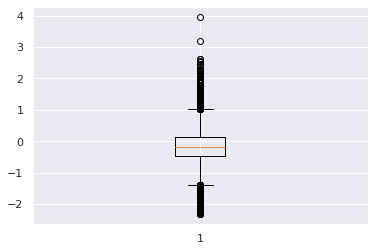

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.figure()
plt.boxplot([diff])
plt.show()

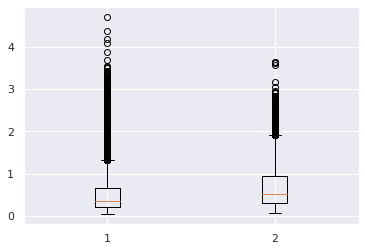

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.figure()
plt.boxplot([res_valid_metrics[1]['L1'], errors])
plt.show()

In [30]:
from arch2vec.models.configs import configs
from info_nas.eval import eval_labeled_validation
from info_nas.models.losses import losses_dict

loss = losses_dict['L1']()

res_test_train = eval_labeled_validation(model, test_train, device, configs[4], loss)
res_test_valid = eval_labeled_validation(model, test_valid, device, configs[4], loss)

Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).


In [57]:
res_test_train

{'val_loss': 0.4785864004055659,
 'MSE': 0.42201058449546497,
 'L1': 0.4785864004055659,
 'val_loss_min': 0.12228084355592728,
 'val_loss_max': 1.5928020477294922,
 'val_loss_std': 0.31685902707573804,
 'val_loss_median': 0.3498511165380478,
 'seed': 10}

In [ ]:
import glob
import pandas as pd


device = torch.device('cuda')
loss = losses_dict['L1']()
res_dict_train = []
res_dict_valid = []

for i in range(1):
    seed = i + 1
    
    check_path = glob.glob(f'/home/gabi/diplomka/results/with_ref_{seed}/*/model_dense_epoch-29.pt')
    assert len(check_path) == 1
    check_path = check_path[0]

    vae_model, _ = get_arch2vec_model(device=device)
    args = [vae_model, 3, 513]
    model, chdata = load_extended_vae(check_path, args, device=device)
    
    res_test_valid = eval_labeled_validation(model, test_valid, device, configs[4], loss)
    res_test_valid['seed'] = seed
    
    res_dict_train.append(res_test_train)
    res_dict_valid.append(res_test_valid)
    
res_dict_train = pd.DataFrame(res_dict_train)
res_dict_valid = pd.DataFrame(res_dict_valid)

In [33]:
import glob
import pandas as pd


device = torch.device('cuda')
loss = losses_dict['L1']()
res_dict_train = []
res_dict_valid = []

for i in range(10):
    seed = i + 1
    
    check_path = glob.glob(f'/home/gabi/diplomka/results/with_ref_{seed}/*/model_dense_epoch-29.pt')
    assert len(check_path) == 1
    check_path = check_path[0]

    vae_model, _ = get_arch2vec_model(device=device)
    args = [vae_model, 3, 513]
    model, chdata = load_extended_vae(check_path, args, device=device)
    
    res_test_train = eval_labeled_validation(model, test_train, device, configs[4], loss)
    res_test_valid = eval_labeled_validation(model, test_valid, device, configs[4], loss)
    
    res_test_train['seed'] = seed
    res_test_valid['seed'] = seed
    
    res_dict_train.append(res_test_train)
    res_dict_valid.append(res_test_valid)
    
res_dict_train = pd.DataFrame(res_dict_train)
res_dict_valid = pd.DataFrame(res_dict_valid)

Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches).
Evaluating model on labeled validation set (4813 batches).
Evaluating model on labeled validation set (3750 batches

In [ ]:
# TODO heatmapa after shuffle whole train, tady

In [58]:
res_dict_train

,val_loss,MSE,L1,val_loss_min,val_loss_max,val_loss_std,val_loss_median,seed
0,0.637992,0.797114,0.637992,0.109509,2.297834,0.529914,0.384903,1
1,0.501865,0.448838,0.501865,0.109902,1.877851,0.332033,0.379124,2
2,0.650062,0.723614,0.650062,0.123620,1.767523,0.435550,0.548275,3
3,0.591617,0.643548,0.591617,0.122733,2.068996,0.442344,0.441714,4
4,0.469576,0.417691,0.469576,0.126176,1.522139,0.302505,0.390122,5
5,0.553589,0.580697,0.553589,0.114533,1.709669,0.376362,0.451897,6
6,0.475752,0.423875,0.475752,0.123973,1.767693,0.344514,0.351208,7
7,0.515150,0.505472,0.515150,0.121657,1.815884,0.389578,0.364429,8
8,0.612325,0.718016,0.612325,0.117387,2.176997,0.497484,0.399926,9
9,0.478586,0.422011,0.478586,0.122281,1.592802,0.316859,0.349851,10


In [39]:
import os

baselines = {}
base_files = ['test_train_long_baseline.csv',
             'test_valid_long_baseline.csv']

dir_path = '/home/gabi/diplomka/results/with_ref_1/2021-20-07_22-33-41/'
for baseline in base_files:
    baseline_path = os.path.join(dir_path, baseline)
    base_df = pd.read_csv(baseline_path, index_col=0)

    key = 'train' if 'train' in baseline else 'valid'
    baselines[key] = base_df

In [40]:
baselines

{'train':   loss_name      mean       std       min       max    median
 0       MSE  1.007835  0.288054  0.305503  5.837052  0.969078
 1        L1  0.771878  0.104628  0.423839  1.244638  0.766786
 2     Huber  0.411251  0.087890  0.148312  0.839636  0.405889,
 'valid':   loss_name      mean       std       min       max    median
 0       MSE  0.839902  1.126431  0.040740  6.158186  0.313306
 1        L1  0.712835  0.523197  0.113223  2.448826  0.515187
 2     Huber  0.360939  0.423513  0.020163  1.952010  0.151755}

<IPython.core.display.Javascript object>


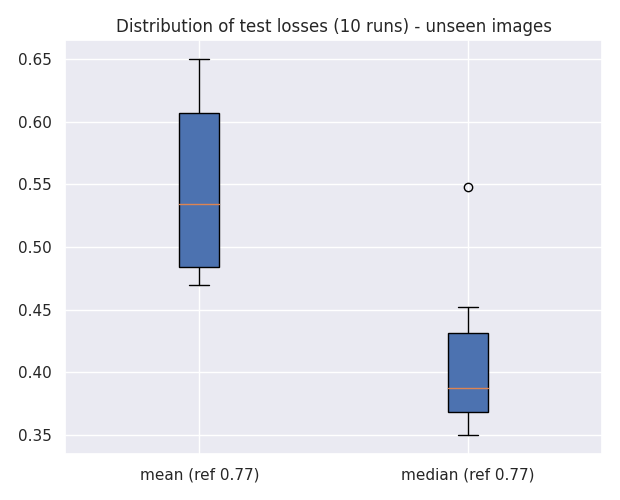

<IPython.core.display.Javascript object>


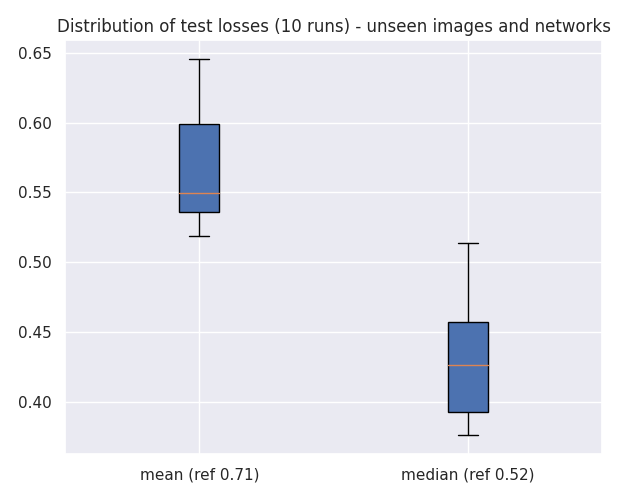

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
sns.set()

save_path = '/home/gabi/diplomka/master-thesis/img/info-losses/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

titles = [
    'Distribution of test losses (10 runs) - unseen images',
    'Distribution of test losses (10 runs) - unseen images and networks'
]

for res, name, title in zip([res_dict_train, res_dict_valid], ['train', 'valid'], titles):
    mean = res['val_loss']
    median = res['val_loss_median']
    
    ref_mean = baselines[name].iloc[1]['mean'].round(2)
    ref_median = baselines[name].iloc[1]['median'].round(2)
    
    plt.figure(figsize=(6.2,5))
    plt.boxplot([mean, median], labels=[f'mean (ref {ref_mean})', f'median (ref {ref_median})'],
               patch_artist=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'boxplots-test-{name}.png'), dpi=500)
    plt.show()